# CVE Statistics Notebook  
**OS Command Injection (CWE‑78) & IoT CVEs – 2020‑2024**

This notebook:

1. Counts all published **CWE‑78** vulnerabilities per year (2020 → 2024) and shows their CVSS‑v3 severity distribution.  
2. Lists the **Top 3 highest‑scoring CWE‑78 CVEs** for each year with English descriptions.  
3. Builds a similar severity‑distribution chart for **IoT‑related** CVEs (keyword “IoT”).

Uses the NVD 2.0 API – you’ll need a free API key from <https://nvd.nist.gov/developers/request-an-api-key>.


In [ ]:
import requests, datetime as dt, pandas as pd, matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", None)

# -------------------------------------------------------------
# 🔑 NVD API key
API_KEY = "KEY HERE"
# -------------------------------------------------------------

YEARS   = range(2020, 2025)               # 2020‑2024 inclusive
SEVS    = ["LOW", "MEDIUM", "HIGH", "CRITICAL"]
UA_HDRS = {"apiKey": API_KEY, "User-Agent": "cwe78-stats"}   # ASCII UA

def nvd_total(url: str) -> int:
    """Return 'totalResults' for a query (resultsPerPage=1)."""
    r = requests.get(url + "&resultsPerPage=1&startIndex=0", headers=UA_HDRS)
    r.raise_for_status()
    return r.json()["totalResults"]

def nvd_paged(url_base: str) -> list:
    """Return the full 'vulnerabilities' list, handling 2k‑row pages."""
    items, start, page = [], 0, 2000
    while True:
        url = f"{url_base}&resultsPerPage={page}&startIndex={start}"
        r   = requests.get(url, headers=UA_HDRS)
        r.raise_for_status()
        data = r.json()
        items.extend(data.get("vulnerabilities", []))
        start += page
        if start >= data.get("totalResults", 0):
            break
    return items

def best_v3_score(metrics: dict) -> float:
    """Pick the highest CVSS v3.x base‑score available."""
    if metrics.get("cvssMetricV31"):
        return metrics["cvssMetricV31"][0]["cvssData"]["baseScore"]
    if metrics.get("cvssMetricV30"):
        return metrics["cvssMetricV30"][0]["cvssData"]["baseScore"]
    return 0.0


| CVSS v3 severity | Base‑score range |
|------------------|------------------|
| **LOW**          | 0.1 – 3.9 |
| **MEDIUM**       | 4.0 – 6.9 |
| **HIGH**         | 7.0 – 8.9 |
| **CRITICAL**     | 9.0 – 10.0 |


Severity,CRITICAL,HIGH,LOW,MEDIUM
Year,,,,
2020,225,251,0,35
2021,160,219,1,44
2022,284,234,0,20
2023,171,297,0,34
2024,130,241,2,24


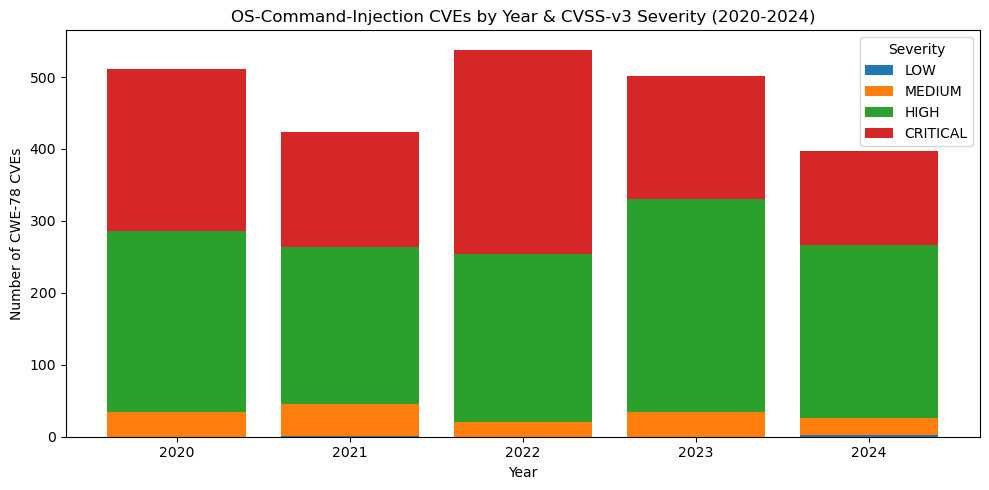

In [4]:
# --- counts per severity per year ---------------------------------
rows = []
for yr in YEARS:
    for sev in SEVS:
        total = 0
        for start in (dt.date(yr,1,1), dt.date(yr,5,1), dt.date(yr,9,1)):   # ≤120 days each
            end = min(start + dt.timedelta(days=119), dt.date(yr,12,31))
            url = (
                "https://services.nvd.nist.gov/rest/json/cves/2.0"
                f"?cweId=CWE-78"
                f"&cvssV3Severity={sev}"
                f"&pubStartDate={start}T00:00:00.000Z"
                f"&pubEndDate={end}T23:59:59.999Z"
            )
            total += nvd_total(url)
        rows.append({"Year": yr, "Severity": sev, "Count": total})

df_cwe78 = (
    pd.DataFrame(rows)
      .pivot(index="Year", columns="Severity", values="Count")
      .fillna(0).astype(int)
)
display(df_cwe78)

# --- stacked bar ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10,5))
bottom = None
for sev in SEVS:
    ax.bar(df_cwe78.index, df_cwe78[sev], bottom=bottom, label=sev)
    bottom = df_cwe78[sev] if bottom is None else bottom + df_cwe78[sev]

ax.set_xlabel("Year")
ax.set_ylabel("Number of CWE‑78 CVEs")
ax.set_title("OS‑Command‑Injection CVEs by Year & CVSS‑v3 Severity (2020‑2024)")
ax.legend(title="Severity")
plt.tight_layout(); plt.show()


In [5]:
top_rows = []
for yr in YEARS:
    vulns = []
    for start in (dt.date(yr,1,1), dt.date(yr,5,1), dt.date(yr,9,1)):
        end = min(start + dt.timedelta(days=119), dt.date(yr,12,31))
        url = (
            "https://services.nvd.nist.gov/rest/json/cves/2.0"
            f"?cweId=CWE-78"
            f"&pubStartDate={start}T00:00:00.000Z"
            f"&pubEndDate={end}T23:59:59.999Z"
        )
        vulns.extend(nvd_paged(url))

    scored = []
    for v in vulns:
        cve  = v["cve"]["id"]
        score = best_v3_score(v["cve"].get("metrics", {}))
        desc  = next((d["value"] for d in v["cve"]["descriptions"] if d["lang"] == "en"), "")
        scored.append((cve, score, desc))

    top3 = sorted(scored, key=lambda t: (-t[1], t[0]))[:3]
    for rank, (cve, score, desc) in enumerate(top3, 1):
        top_rows.append({"Year": yr, "Rank": rank, "CVE": cve, "CVSSv3": score, "Description": desc})

df_top3 = pd.DataFrame(top_rows)
for yr in YEARS:
    display(
        df_top3[df_top3["Year"] == yr][["Rank", "CVE", "CVSSv3", "Description"]]
        .style.set_caption(f"Top 3 CWE‑78 CVEs in {yr}")
        #.hide_index()
    )


,Rank,CVE,CVSSv3,Description
0,1,CVE-2020-12522,10.000000,"The reported vulnerability allows an attacker who has network access to the device to execute code with specially crafted packets in WAGO Series PFC 100 (750-81xx/xxx-xxx), Series PFC 200 (750-82xx/xxx-xxx), Series Wago Touch Panel 600 Standard Line (762-4xxx), Series Wago Touch Panel 600 Advanced Line (762-5xxx), Series Wago Touch Panel 600 Marine Line (762-6xxx) with firmware versions <=FW10."
1,2,CVE-2020-6364,10.000000,"SAP Solution Manager and SAP Focused Run (update provided in WILY_INTRO_ENTERPRISE 9.7, 10.1, 10.5, 10.7), allows an attacker to modify a cookie in a way that OS commands can be executed and potentially gain control over the host running the CA Introscope Enterprise Manager,leading to Code Injection. With this, the attacker is able to read and modify all system files and also impact system availability."
2,3,CVE-2019-5138,9.900000,"An exploitable command injection vulnerability exists in encrypted diagnostic script functionality of the Moxa AWK-3131A firmware version 1.13. A specially crafted diagnostic script file can cause arbitrary busybox commands to be executed, resulting in remote control over the device. An attacker can send diagnostic while authenticated as a low privilege user to trigger this vulnerability."


,Rank,CVE,CVSSv3,Description
3,1,CVE-2020-29495,10.000000,"DELL EMC Avamar Server, versions 19.1, 19.2, 19.3, contain an OS Command Injection Vulnerability in Fitness Analyzer. A remote unauthenticated attacker could potentially exploit this vulnerability, leading to the execution of arbitrary OS commands on the application's underlying OS with high privileges. This vulnerability is considered critical as it can be leveraged to completely compromise the vulnerable application as well as the underlying operating system. Dell recommends customers to upgrade at the earliest opportunity."
4,2,CVE-2021-22657,10.000000,"mySCADA myPRO: Versions 8.20.0 and prior has a feature where the API password can be specified, which may allow an attacker to inject arbitrary operating system commands through a specific parameter."
5,3,CVE-2021-23198,10.000000,"mySCADA myPRO: Versions 8.20.0 and prior has a feature where the password can be specified, which may allow an attacker to inject arbitrary operating system commands through a specific parameter."


,Rank,CVE,CVSSv3,Description
6,1,CVE-2021-27476,10.000000,"A vulnerability exists in the SaveConfigFile function of the RACompare Service, which may allow for OS command injection. This vulnerability may allow a remote, unauthenticated attacker to execute arbitrary commands in Rockwell Automation FactoryTalk AssetCentre v10.00 and earlier."
7,2,CVE-2021-32933,10.000000,An attacker could leverage an API to pass along a malicious file that could then manipulate the process creation command line in MDT AutoSave versions prior to v6.02.06 and run a command line argument. This could then be leveraged to run a malicious process.
8,3,CVE-2022-20708,10.000000,"Multiple vulnerabilities in Cisco Small Business RV160, RV260, RV340, and RV345 Series Routers could allow an attacker to do any of the following: Execute arbitrary code Elevate privileges Execute arbitrary commands Bypass authentication and authorization protections Fetch and run unsigned software Cause denial of service (DoS) For more information about these vulnerabilities, see the Details section of this advisory."


,Rank,CVE,CVSSv3,Description
9,1,CVE-2023-2131,10.000000,"Versions of INEA ME RTU firmware prior to 3.36 are vulnerable to OS command injection, which could allow an attacker to remotely execute arbitrary code."
10,2,CVE-2023-2564,10.000000,OS Command Injection in GitHub repository sbs20/scanservjs prior to v2.27.0.
11,3,CVE-2023-3572,10.000000,"In PHOENIX CONTACTs WP 6xxx series web panels in versions prior to 4.0.10 a remote, unauthenticated attacker may use an attribute of a specific HTTP POST request releated to date/time operations to gain full access to the device."


,Rank,CVE,CVSSv3,Description
12,1,CVE-2024-1212,10.000000,"Unauthenticated remote attackers can access the system through the LoadMaster management interface, enabling arbitrary system command execution."
13,2,CVE-2024-1297,10.000000,Loomio version 2.22.0 allows executing arbitrary commands on the server. This is possible because the application is vulnerable to OS Command Injection.
14,3,CVE-2024-23108,10.000000,An improper neutralization of special elements used in an os command ('os command injection') in Fortinet FortiSIEM version 7.1.0 through 7.1.1 and 7.0.0 through 7.0.2 and 6.7.0 through 6.7.8 and 6.6.0 through 6.6.3 and 6.5.0 through 6.5.2 and 6.4.0 through 6.4.2 allows attacker to execute unauthorized code or commands via via crafted API requests.


Severity,CRITICAL,HIGH,LOW,MEDIUM
Year,,,,
2020,102,182,0,31
2021,62,137,0,46
2022,56,165,1,50
2023,8,9,0,5
2024,5,17,0,5


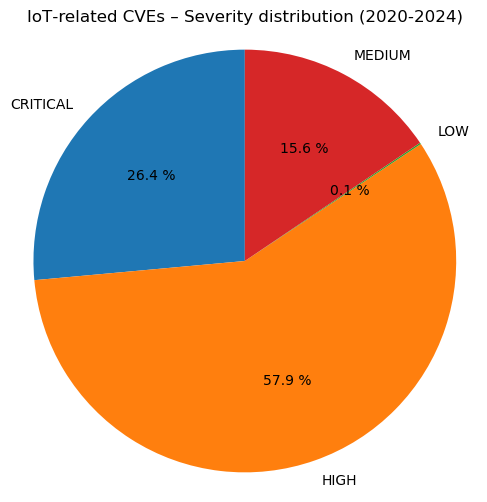

In [6]:
rows = []
for yr in YEARS:
    for sev in SEVS:
        total = 0
        for start in (dt.date(yr,1,1), dt.date(yr,5,1), dt.date(yr,9,1)):
            end = min(start + dt.timedelta(days=119), dt.date(yr,12,31))
            url = (
                "https://services.nvd.nist.gov/rest/json/cves/2.0"
                f"?keywordSearch=IoT"
                f"&cvssV3Severity={sev}"
                f"&pubStartDate={start}T00:00:00.000Z"
                f"&pubEndDate={end}T23:59:59.999Z"
            )
            total += nvd_total(url)
        rows.append({"Year": yr, "Severity": sev, "Count": total})

df_iot = (
    pd.DataFrame(rows)
      .pivot(index="Year", columns="Severity", values="Count")
      .fillna(0).astype(int)
)
display(df_iot)

# Collapse all years into one total row
totals = df_iot.sum()          # Series indexed by severity
labels = totals.index
sizes  = totals.values

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f"{p:.1f} %",      # percentage on slices
    startangle=90
)
ax.set_title("IoT‑related CVEs – Severity distribution (2020‑2024)")
ax.axis("equal")   # keep the pie a circle
plt.show()


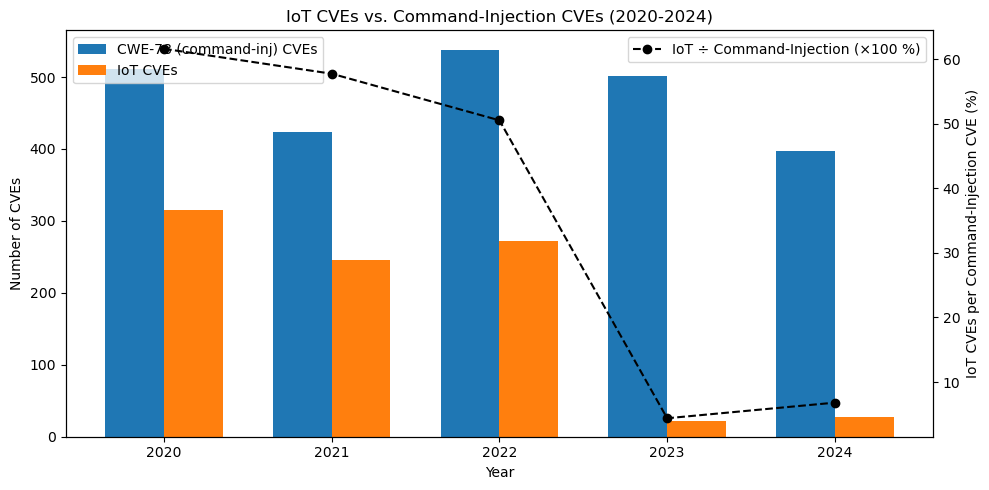

In [8]:
# ------------------------------------------------------------------
# IoT vs. Command‑Injection CVEs (2020‑2024)
# ------------------------------------------------------------------

# Totals per year
cmd_totals = df_cwe78.sum(axis=1)   # Series, index = Year
iot_totals = df_iot.sum(axis=1)

ratio = (iot_totals / cmd_totals).replace([np.inf, np.nan], 0)  # safety

# --- bar + ratio line --------------------------------------------
import numpy as np
x = np.arange(len(YEARS))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,5))

bars_cmd = ax1.bar(x - width/2, cmd_totals, width,
                   label="CWE‑78 (command‑inj) CVEs")
bars_iot = ax1.bar(x + width/2, iot_totals, width,
                   label="IoT CVEs")

ax1.set_xlabel("Year")
ax1.set_ylabel("Number of CVEs")
ax1.set_title("IoT CVEs vs. Command‑Injection CVEs (2020‑2024)")
ax1.set_xticks(x, YEARS)
ax1.legend(loc="upper left")

# dashed ratio line on twin y‑axis
ax2 = ax1.twinx()
ax2.plot(x, ratio * 100, color="black", marker="o",
         linestyle="--", label="IoT ÷ Command‑Injection (×100 %)")
ax2.set_ylabel("IoT CVEs per Command‑Injection CVE (%)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [9]:
df_cwe78.to_csv("cwe78_counts_2020_2024.csv")
df_iot.to_csv("iot_counts_2020_2024.csv")
df_top3.to_csv("cwe78_top3_per_year.csv", index=False)
print("CSV files saved.")


CSV files saved.
